# QOSF Cohort 8 Screening Task-3: Decompose

### Problem Statement
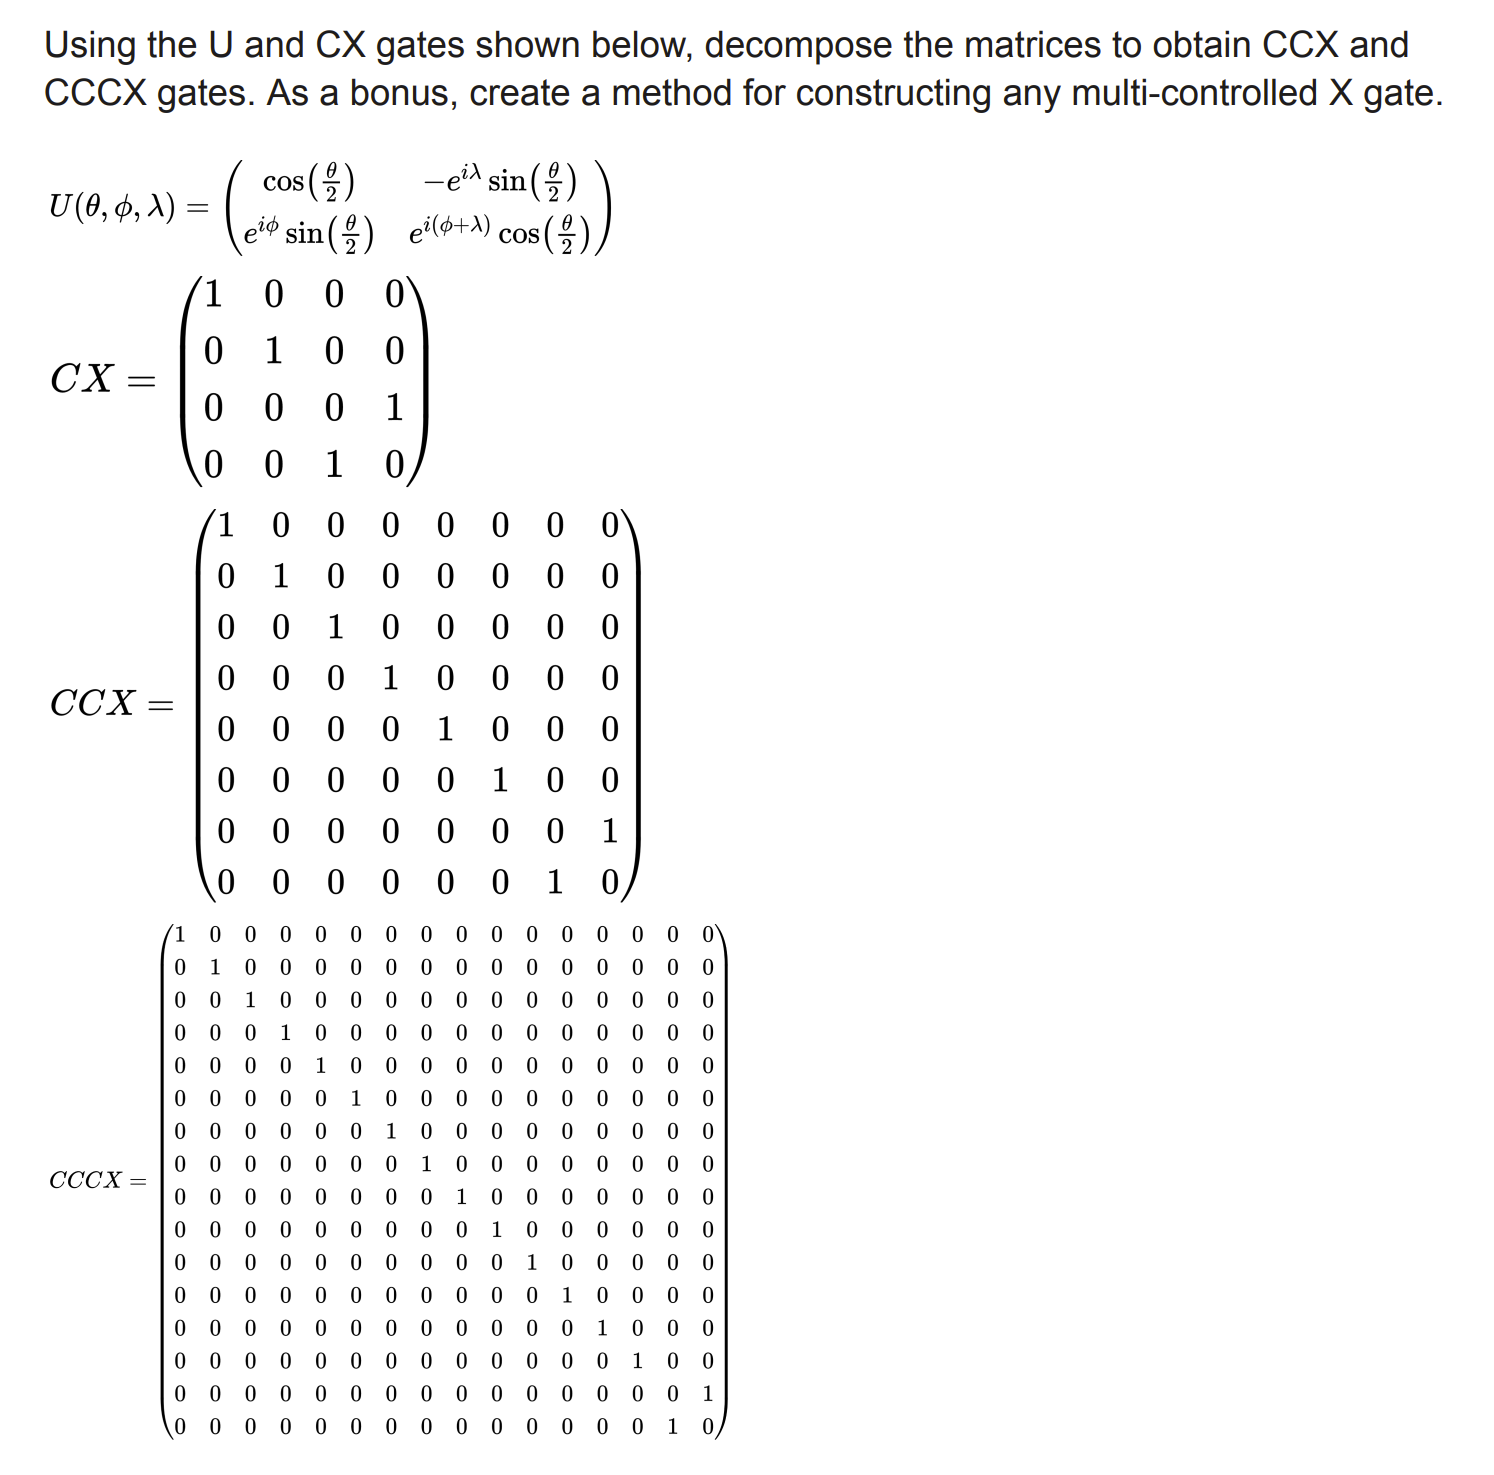

In [139]:
import numpy as np
import qiskit
import pylatexenc
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import *
from qiskit.circuit.library import U3Gate, XGate
from qiskit.tools.jupyter import *
from qiskit.visualization import *

## Decomposing the Toffoli Gate (CCX)

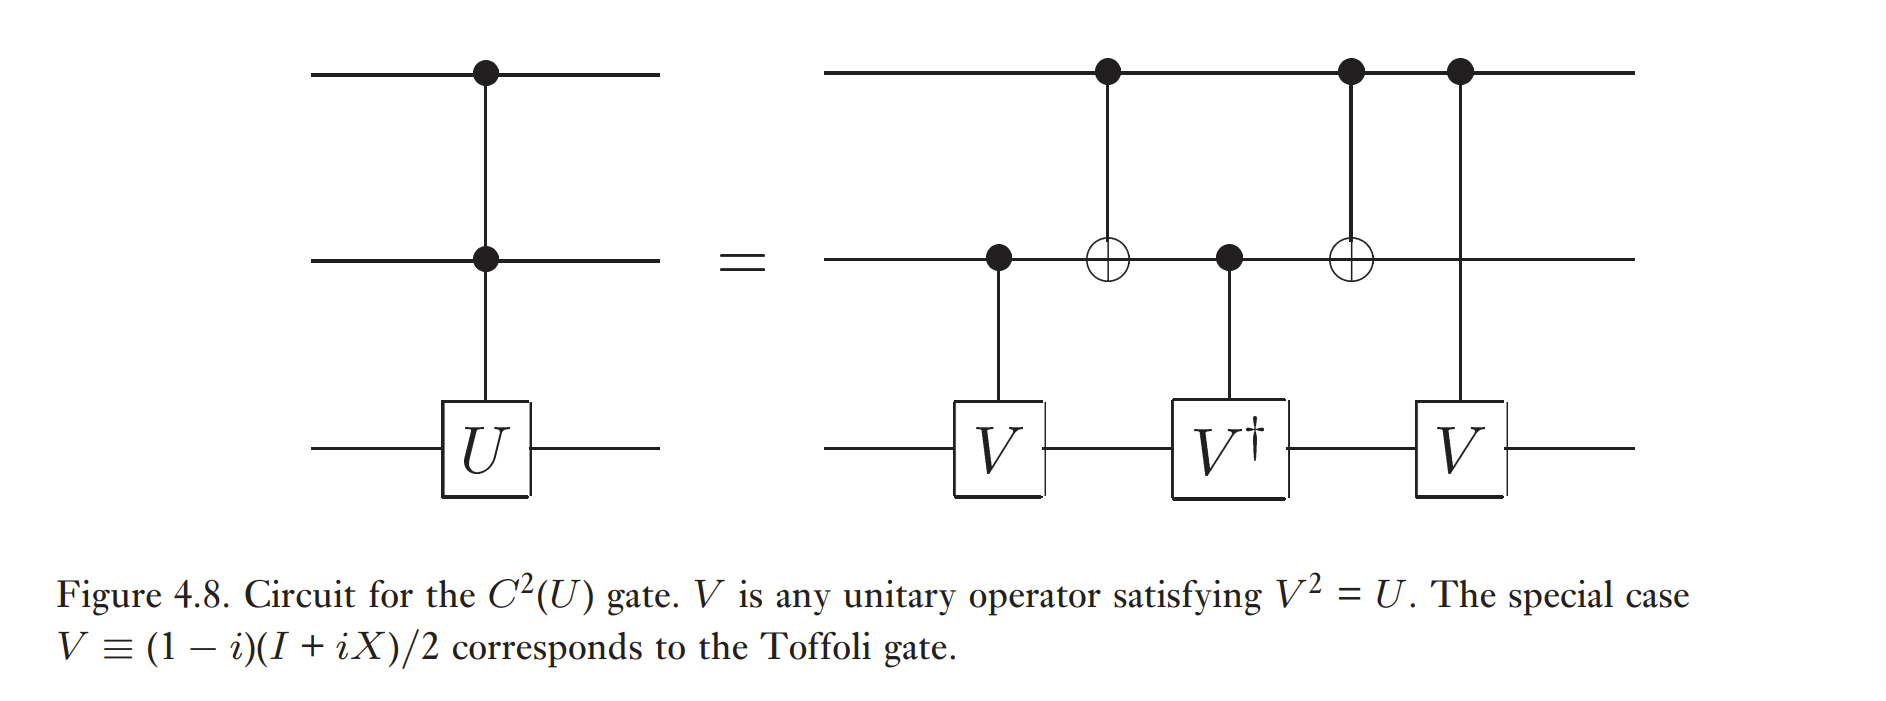

as mentioned in the figure caption, we can find the V gate to be $V = \frac{(1-i)}{2}(I+ iX)$ or 

$$V = \frac{1}{2}\begin{bmatrix} 1-i  & 1+i\\ 1+i & 1-i \end{bmatrix}$$


Since we are limited to normal _U_ and _CX_ gates, we must further decompose the _controlled-V_ gate to single _U_ and _CX_ gates by this form 

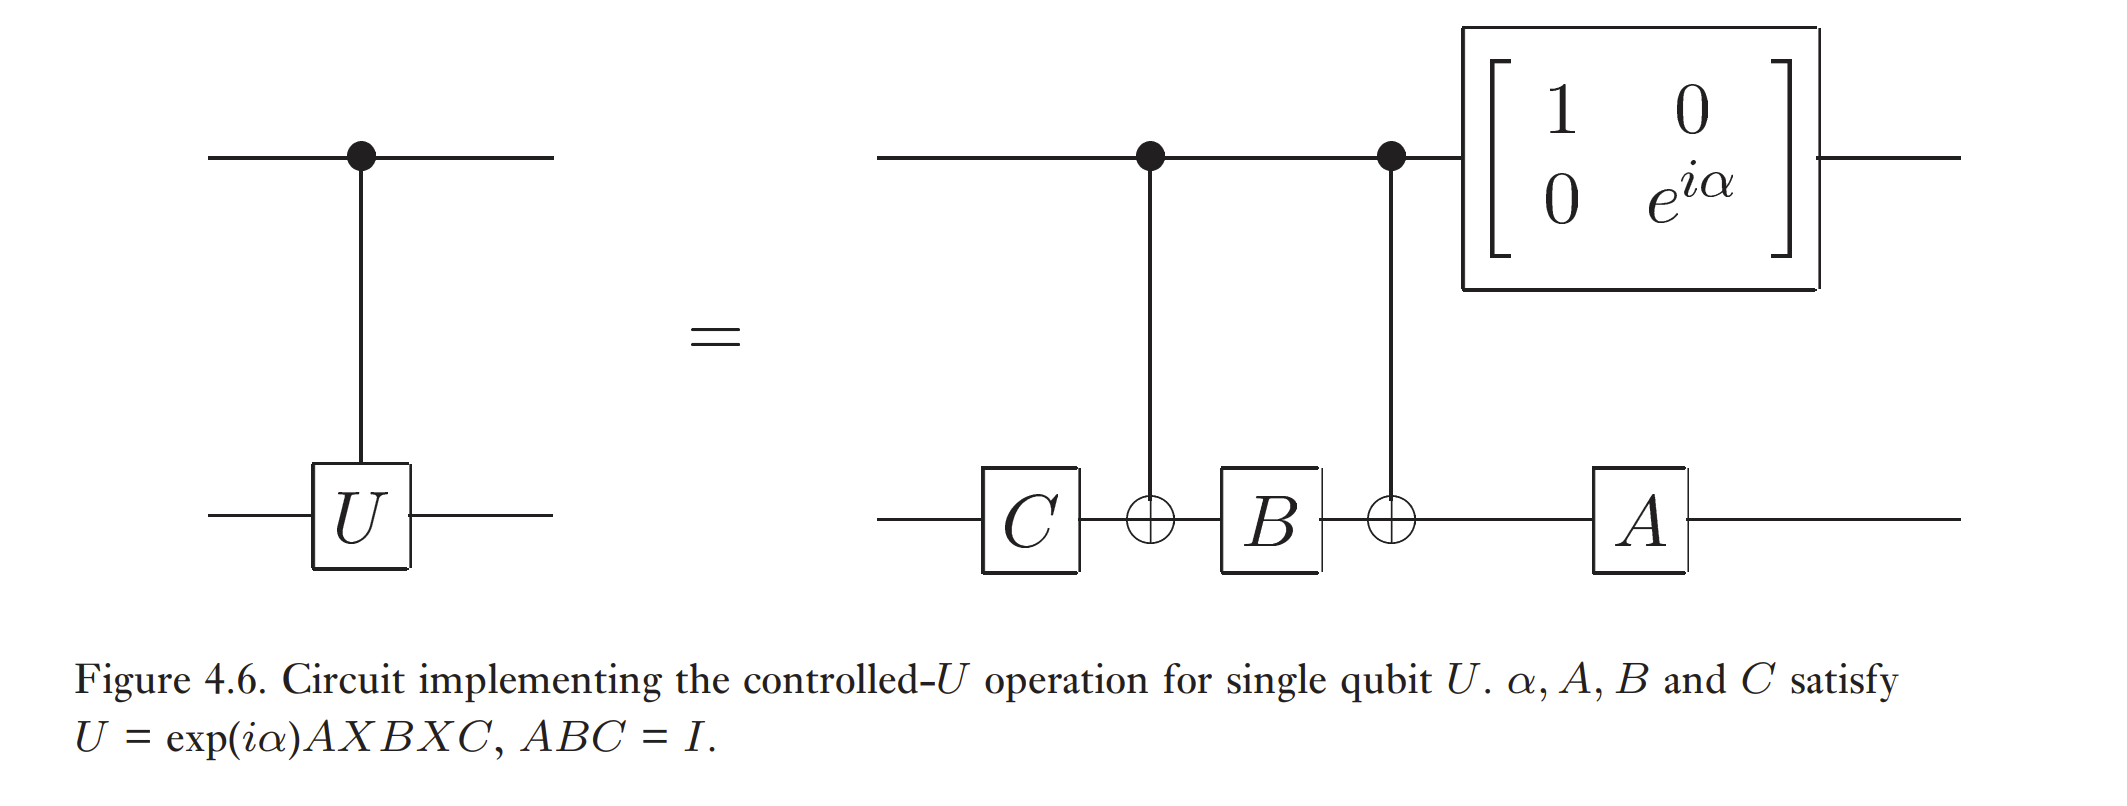

We must determine what _A,B,C_ under the mentioned conditions give us our _V_

In [147]:
decomposer=OneQubitEulerDecomposer(basis='ZYZ')
angles = decomposer.angles([[0.5-0.5j,0.5+0.5j],[0.5+0.5j,0.5-0.5j]])
#returns theta, ,phi, lambda 
print(angles) 

(1.5707963267948966, 1.5707963267948966, -1.5707963267948966)


Parametrizing $V = R_z(\theta)R_y(\phi)R_z(\lambda)$ we find the values as $\theta = \pi/2$ $\phi = \pi/2;$ $\lambda = -\pi/2$, we must find suitable $A, B, C, \alpha$ for the following parameters. 

Analogous to the solution in https://quantumcomputing.stackexchange.com/a/18277, A decomposition that fits for the required $U$ gives us $A, B, C, \alpha$ is  

$$A = R_z(\frac{-\pi}{2})R_y(\frac{\pi}{4}), \ B = R_y(\frac{-\pi}{4}), \ C = R_z(\frac{\pi}{2}), \ \alpha = \frac{\pi}{4}$$

We can now completely implement Fig 4.8 with our limited gates as follows

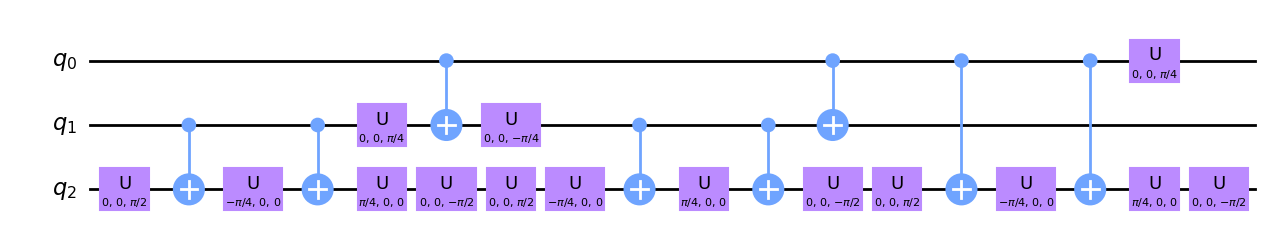

In [99]:
ccx_circuit = QuantumCircuit(3)

#Apply the controlled V gate
def V_gate(qc, control, target):
    qc.u(0, 0, np.pi/2, target)
    qc.cx(control, target)
    qc.u(-np.pi/4, 0, 0, target)
    qc.cx(control, target)    
    qc.u(np.pi/4, 0, 0, target)
    qc.u(0, 0, -np.pi/2, target)
    qc.u(0, 0, np.pi/4, control)
#Apply the controlled V inverse gate
def Vdg_gate(qc, control, target):
    qc.u(0, 0, np.pi/2, target)
    qc.u(0, 0, -np.pi/4, control)
    qc.u(-np.pi/4, 0, 0, target)
    qc.cx(control, target)
    qc.u(np.pi/4, 0, 0, target)
    qc.cx(control, target)
    qc.u(0, 0, -np.pi/2, target)

#decomposing the toffoli gate according to the figure
V_gate(ccx_circuit, 1, 2)
ccx_circuit.cx(0,1)
Vdg_gate(ccx_circuit, 1, 2)
ccx_circuit.cx(0,1)
V_gate(ccx_circuit, 0, 2)

ccx_circuit.draw(output='mpl')

In [108]:
print('Circuit Depth : '+str(ccx_circuit.depth()))
ccx_circuit.to_gate()
array_to_latex(Operator(ccx_circuit))

Circuit Depth : 18


<IPython.core.display.Latex object>

# ATTENTION

Since Qiskit's endianness is the opposite of conventional textbook endinanness, instead of the $CCX$ Matrix given in our problem statment we should expect to see such a matrix

In [112]:
test = QuantumCircuit(3)
test.ccx(0,1,2)
test.to_gate()
array_to_latex(Operator(test))

<IPython.core.display.Latex object>

## Result

Removing the redundancies such as neighbouring $U$ and $U^\dagger$s and the repeating $CNOT$s, we are left with a reduced final circuit

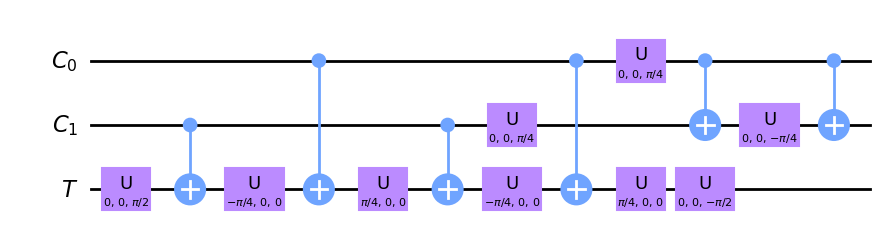

In [115]:
def CCX_gate(qc, c1, c2, t):
    qc.u(0, 0, np.pi/2, t)
    qc.cx(c1, t)
    qc.u(-np.pi/4, 0, 0, t)
    qc.cx(c2, t)
    qc.u(np.pi/4, 0, 0, t)
    qc.cx(c1, t)
    qc.u(-np.pi/4, 0, 0, t)
    qc.cx(c2, t)
    qc.u(np.pi/4, 0, 0, t)
    qc.u(0, 0, -np.pi/2, t)
    qc.u(0, 0, np.pi/4, c2)
    qc.u(0, 0, np.pi/4, c1)
    qc.cx(c2, c1)
    qc.u(0, 0, -np.pi/4, c1)
    qc.cx(c2, c1)

control = QuantumRegister(2, name='C')
target = QuantumRegister(1, name='T')
toffoli = QuantumCircuit(control, target)

CCX_gate(toffoli, 1, 0, 2)
toffoli.draw(output='mpl')

In [109]:
print('Cicruit Depth: '+str(toffoli.depth()))
toffoli.to_gate()
array_to_latex(Operator(toffoli))

Cicruit Depth: 12


<IPython.core.display.Latex object>

## Decomposing the CCCX Gate

We can decompose our CCCX gate using the following formula 

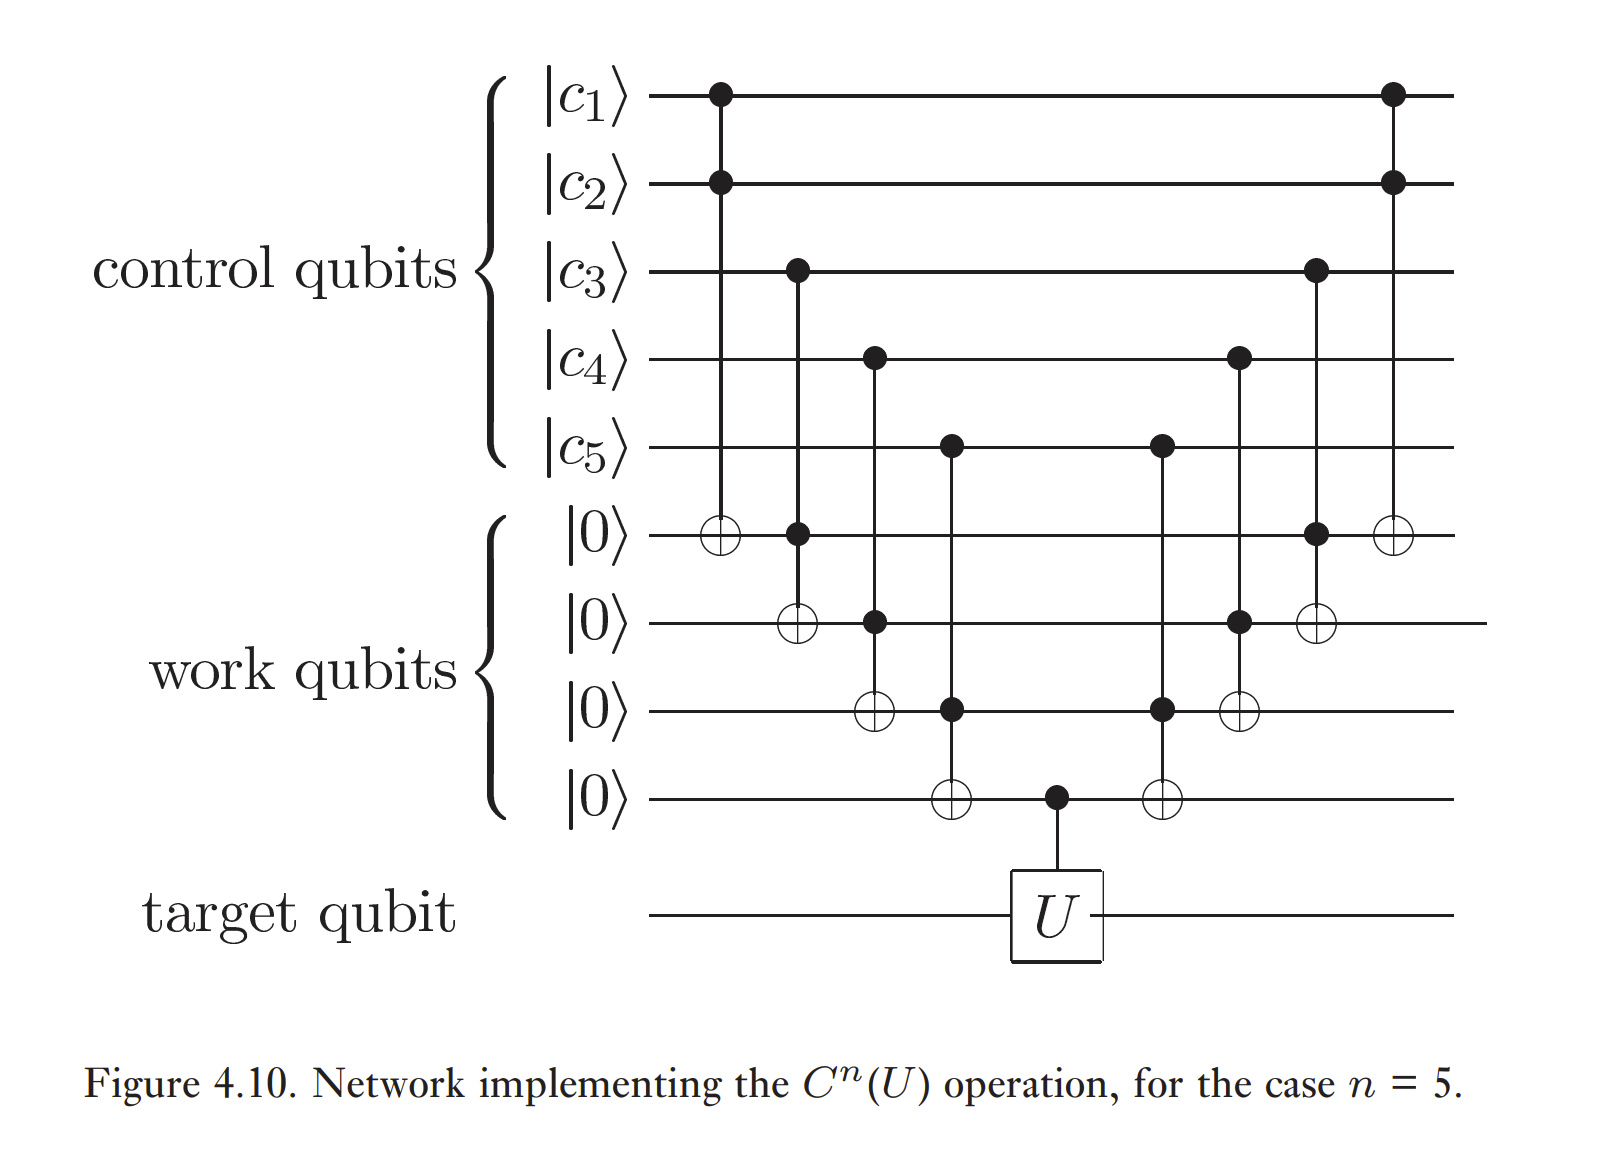

Building from the already constructued CCX gate, we can construct the CCCX gate using just 1 working qubit

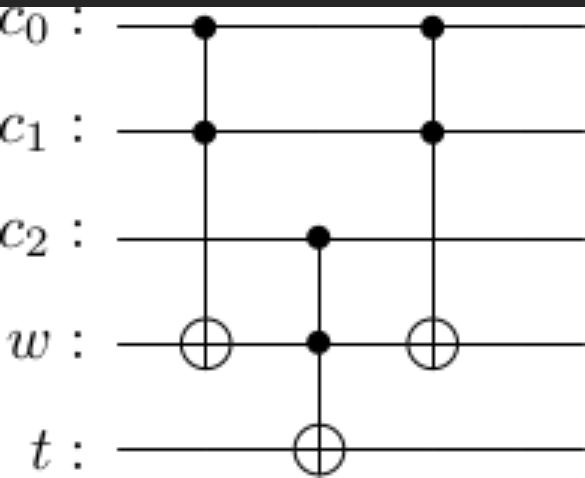

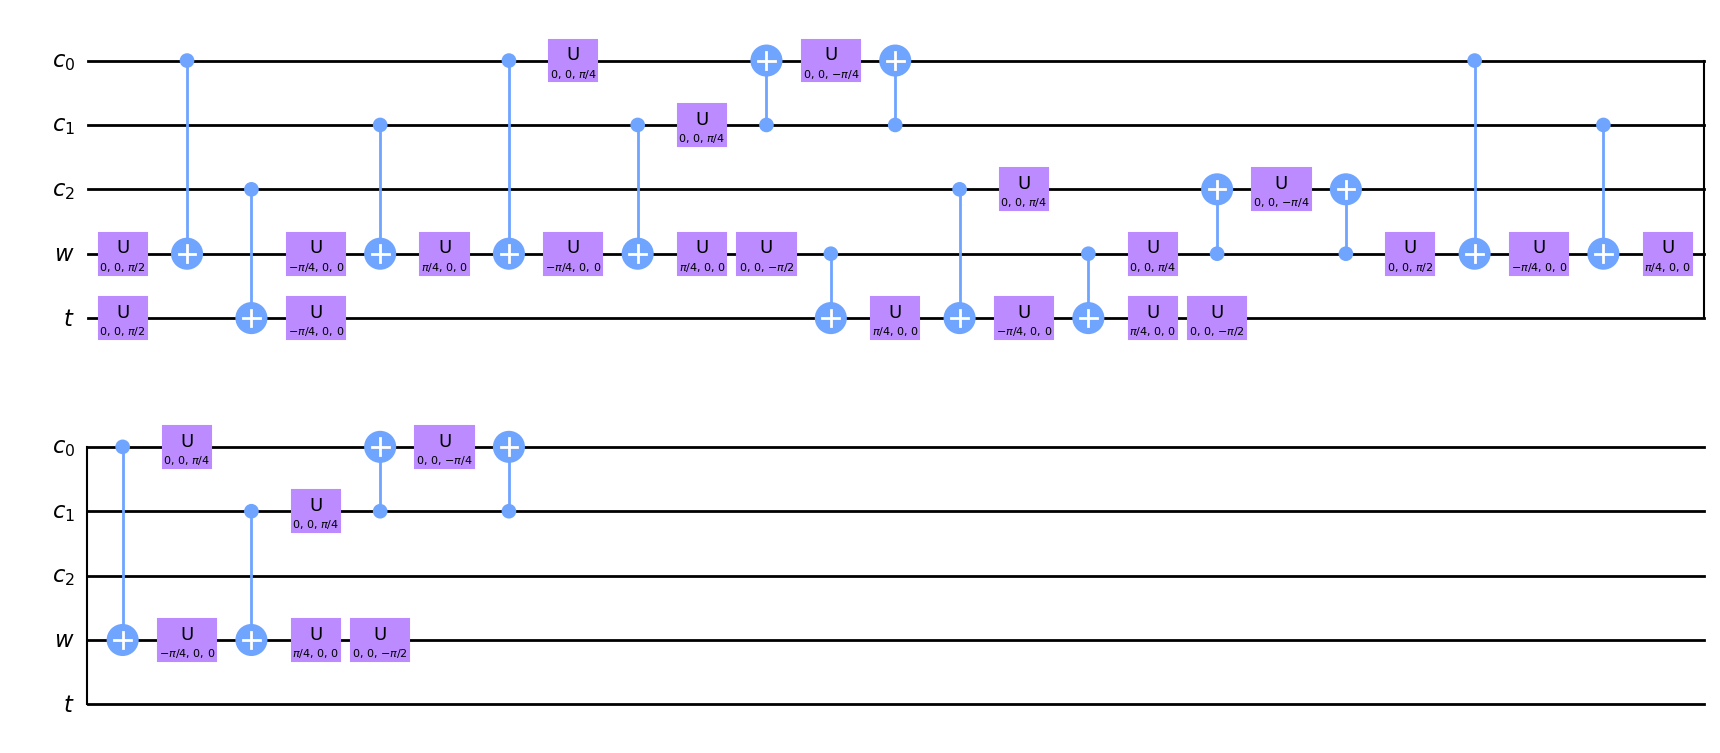

In [146]:
control = QuantumRegister(3,'c')
working = QuantumRegister(1,'w')
target = QuantumRegister(1,'t')
cccx_circuit = QuantumCircuit(control, working, target)

CCX_gate(cccx_circuit, 0, 1, 3)
CCX_gate(cccx_circuit, 2, 3, 4)
CCX_gate(cccx_circuit, 0, 1, 3)

cccx_circuit.draw('mpl')

## Bonus - Decomposing any C$^n$X Gate

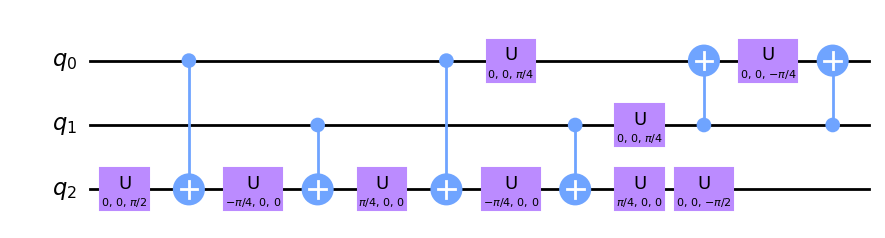

In [151]:
def CNX(n):
    if n<2:
        print('Invalid Circuit, not enough qubits')
    elif n == 2:
        qc = QuantumCircuit(2)
        qc.cx(0,1)
        return qc.to_gate()
    elif n == 3:
        qc = QuantumCircuit(3)
        CCX_gate(qc, 0, 1, 2)
    else:
        control = QuantumRegister(n, 'c')
        working = QuantumRegister(n-2, 'w') 
        target = QuantumRegister(1, 't')
        qc = QuantumCircuit(control, working, target)
        #to-do figure out iterations of ccx gate
    
    return qc

CNX(3).draw()